In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, make_scorer, precision_recall_curve, recall_score, classification_report
from skopt import BayesSearchCV

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

In [4]:
path = '/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/data/clean/'
filename = "training.csv"
train = pd.read_csv(path + filename, index_col=0)
train.drop(["SK_ID_CURR"], axis=1, inplace=True) # l'id du client n'est pas une feature 
print(train.shape)
train.head()

(307507, 241)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,PREV_GRANTED_ASKED_RATIO,PREV_PERC_INSU_NOT_REQ,PREV_CHAN_AP+,PREV_WALKIN,PREV_REJECT_SCOFR,PREV_REFUS_NAME_GOAL,PREV_GOAL_HOBBY,NB_CASH_CONTRACT_AMOR_DEBT,NB_CASH_CONTRACT_DEMAND,TARGET
0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1.111967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.828021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,1.071609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,1.107012,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
y = train["TARGET"]
X = train.drop(["TARGET"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42) # stratify ??

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215254, 240), (92253, 240), (215254,), (92253,))

In [6]:
# normalisation des données pour le test des modèles de base (la normalisation sera incluse dans la pipeline pour la comparaison des modèles)
# test set normalisé avec les paramètres appris sur le training set (pour éviter data leakage)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèles de base

Il s'agit de calculer la probabilité de remboursement d'un client pour éclairer la décision de lui accorder ou de lui refuser un crédit.

Choix de la metrics à suivre
* Dans ce contexte l'Area Under the Curve (AUC) est la metrics la plus adaptée : il s'agit d'une probabilité entre 0 et 1 (un modèle random génèrera un AUC de 0.5). On cherche donc à maximiser l'AUC
* Par ailleurs, nous avons vu que les targets étaient inbalanced, ce qui biaise l'accuracy (donc mauvais choix de metrics)

## Logistic Regression

In [7]:
lr = LogisticRegression(C=0.0001, max_iter=100)
lr.fit(X_train_scaled, y_train)
lr_score = accuracy_score(y_test, lr.predict(X_test_scaled))
lr_auc = roc_auc_score(y_test, lr.predict(X_test_scaled))
print(f"Accuracy: {lr_score:.4f}")
print(f"AUC : {lr_auc}")

Accuracy: 0.9193
AUC : 0.5


In [8]:
y_train.value_counts(normalize=True).round(5)

TARGET
0    0.91924
1    0.08076
Name: proportion, dtype: float64

* L'accuracy est très bonne mais correspond en fait à la répartition de la target (le modèle prédit tout le temps la classe majoritaire)
* Par ailleurs l'AUC de 0.5 indique que le modèle n'est pas plus performant que si les prédictions étaient faites au hasard.

In [9]:
def plot_auc_conf(model, X_test, y_true, y_pred_proba, auc):
    
    fig = plt.figure(figsize=(20,5))

    plt.subplot(131)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='limegreen', linewidth=3, label='AUC = %0.2f' %auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title(f"R0C curve with {type(model).__name__}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.subplot(132)
    precision,recall,_ = precision_recall_curve(y_true, y_pred_proba)
    plt.plot(precision, recall, color='limegreen', linewidth=3)
    baseline = len(y_test[y_test==1])/len(y_test)
    plt.plot([0, 1], [baseline, baseline], color='darkblue', linestyle='--')
    plt.title(f"PR curve with {type(model).__name__}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.subplot(133)
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    ax = sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=',d')
    ax.set_title(f"Confusion Matrix with {type(model).__name__}")
    ax.set_xlabel("Predicted value")
    ax.set_ylabel("Actual Values")

    plt.show()

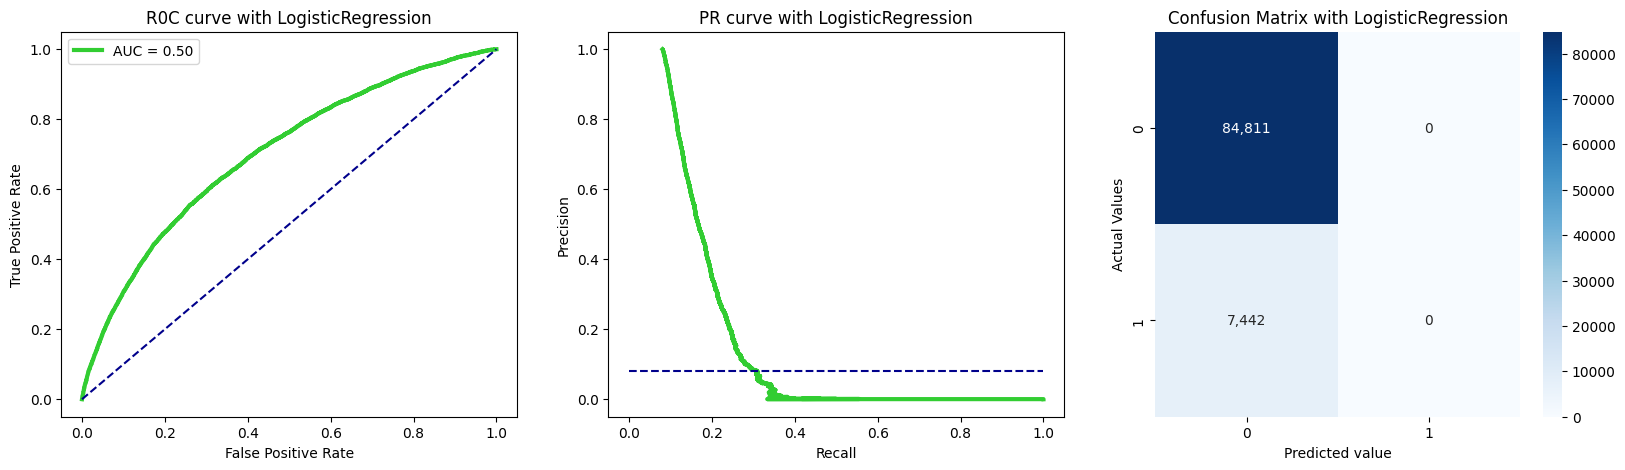

In [10]:
plot_auc_conf(lr, X_test_scaled, y_test, lr.predict_proba(X_test_scaled)[:,1], lr_auc)

## Histogram-based Gradient Boosting Classification Tree

Nous essayons un modèle un peu plus complexe pour voir si les résultats sont similaires (sans traitement du déséquilibrage de données)

In [11]:
xgb_model = HistGradientBoostingClassifier().fit(X_train_scaled,y_train)
xgb_predict = xgb_model.predict(X_test_scaled)
xgb_score = accuracy_score(y_test, xgb_predict)
xgb_auc = roc_auc_score(y_test, xgb_predict)
print(f"Accuracy: {xgb_score:.4f}")
print(f"AUC : {xgb_auc:.4f}")
#15s

Accuracy: 0.9198
AUC : 0.5146


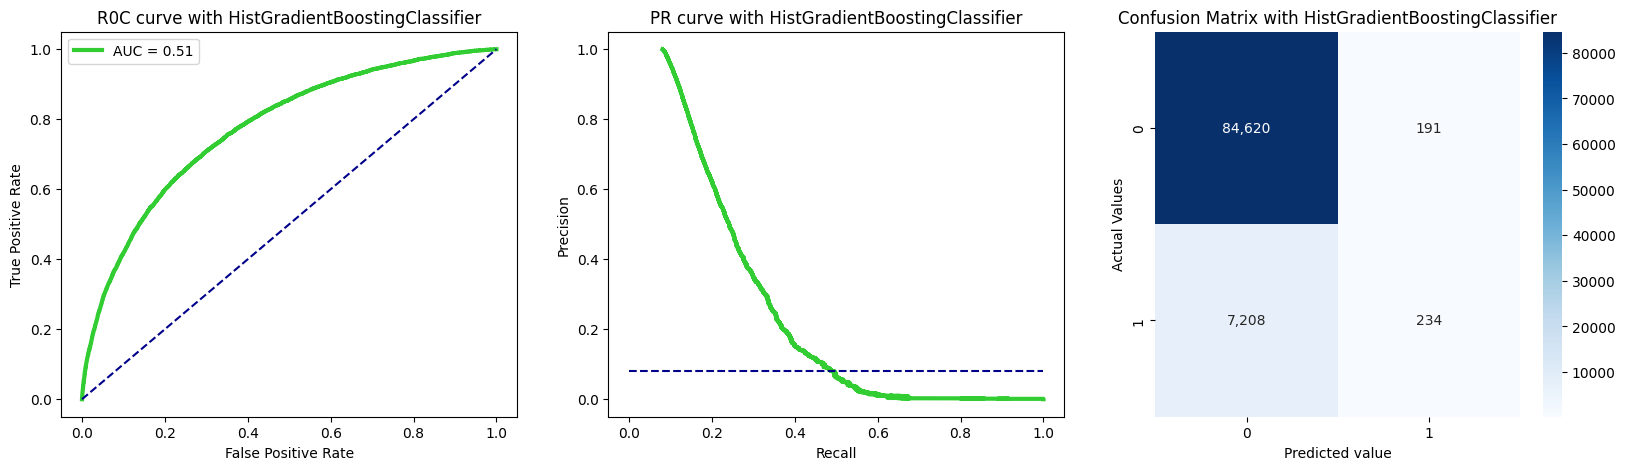

In [12]:
plot_auc_conf(xgb_model, X_test_scaled, y_test, xgb_model.predict_proba(X_test_scaled)[:,1], xgb_auc)

L'accuracy et l'AUC sont légèrement plus élevés car le modèle XGB classe quelques entrées en "1".

# Gestion du déséquilibre de classe

Le déséquilibre de classe doit être pris en compte car les modèle de ML ont tendance à ignorer les classes les moins représentées, alors que c'est la performance du modèle sur ces classes qui est pertinente. Il y a trop peu d'exemples de la classe minoritaire pour que le modèle puisse apprendre correctement la frontière de décision

* solution simple : oversample les exemples de la classe minoritaire en duplicant les observations avant de fitter le modèle
* solution plus avancée : synthètiser de nouvelles observations à partir des exemples de la classe minoritaire ("data augmentation")

In [6]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipeline
from collections import Counter

In [14]:
counter = Counter(y)
for k,v in counter.items():
    counter[k] = f"{v:,.0f}"
counter

Counter({0: '282,682', 1: '24,825'})

### Under sampling

* Advantage : help improve run time & storage problems
* Disadvantage : can discard potentially useful info + chosen subsample might be biased

In [15]:
# balance the data by randomly selecting a subset of data for the targeted classes
rus = RandomUnderSampler(random_state=42, replacement=True)
X_rus, y_rus = rus.fit_resample(X, y)
print(f"Original shape {Counter(y)}")
print(f"Resampled shape {Counter(y_rus)}")

Original shape Counter({0: 282682, 1: 24825})
Resampled shape Counter({0: 24825, 1: 24825})


#### Under-Sampling: Tomek Links

In [16]:
# Tomek links are pairs of very close instances but opposite classes
# removing the instances of the majority class of each pair increases the space between the two classes, which facilitate the classification process
tl = RandomOverSampler(sampling_strategy='majority')
X_tl, y_tl = rus.fit_resample(X, y)
print(f"Original shape {Counter(y)}")
print(f"Resampled shape {Counter(y_tl)}")

Original shape Counter({0: 282682, 1: 24825})
Resampled shape Counter({0: 24825, 1: 24825})


#### Under-sampling : NearMiss

In [17]:
# instead of resampling the minority class, using the distance will make the majority class equal to the minority class
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X,y)
print(f"Original shape {Counter(y)}")
print(f"Resampled shape {Counter(y_nm)}")

Original shape Counter({0: 282682, 1: 24825})
Resampled shape Counter({0: 24825, 1: 24825})


### Over sampling

* Advantage : no information loss
* Disadvantage : increase likelihood of overfitting

In [18]:
# generate new samples in the minority class by random sampling with replacement of the currently available samples
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
print(f"Original shape {Counter(y)}")
print(f"Resampled shape {Counter(y_ros)}")

Original shape Counter({0: 282682, 1: 24825})
Resampled shape Counter({1: 282682, 0: 282682})


### SMOTE

SMOTE est une forme d'oversampling. Fonctionnement:
* sélection au hasard d'une observation faisant partie de la classe minoritaire
* identification des k nearest neighbors de cette observation
* sélection d'un des voisins
* l'observations de synthèse est ajoutée à n'importe quel endroit sur la ligne qui relie l'observation random et son voisin sélectionné
-> à répéter jusqu'à ce que les data soient balanced

In [19]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X,y)
print(f"Original shape {Counter(y)}")
print(f"Resampled shape {Counter(y_smote)}")

Original shape Counter({0: 282682, 1: 24825})
Resampled shape Counter({1: 282682, 0: 282682})


La littérature indique que l'oversampling a tendance à générer de meilleurs résultats que l'undersampling (évite la perte d'information). Par ailleurs, la méthode SMOTE, qui génère de nouveaux points légèrement différents de ceux existant (pas de duplicate), aboutit à de meilleurs résultats.

Nous allons donc nous appuyer sur SMOTE pour gérer notre situation de déséquilibre

# Comparaison de différents modèles

In [7]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.server import get_app_client

Mise en oeuvre d'une démarche MLOps pour automatiser et industrialiser la gestion du cycle de vie du modèle
* tracking d'expérimentation avec MLFlow
* stockage centralisé des modèles dans un "modèle registry"

In [21]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

Nous devons prendre en compte le cout associé avec les FN (prédire qu'un client ne fera pas défaut alors que si) et les FP (prédire qu'un client fera défaut alors que non) :
- nous voulons éviter les couts associés aux FN : prêter de l'argent à des clients qui ne pourront pas rembourser
- les couts associés aux FP ne sont pas aussi dérangeants : correspondent au manque à gagner de ne pas preter à des clients qui peuvent rembourser
- dans notre cas d'espèce, nous allons considérer que les FN sont 10x plus couteux que les FP --> notre scoring doit etre ajusté en fonction
- en plus de maximiser le auc et le recall, nous allons également créer un custom score relatif au cout lié aux erreurs (score à minimiser)

In [8]:
def error_cost(y_true, y_pred):
    """création d'une fonction cout qui calcule le cout des erreurs faites par le modèle

    Args:
        y_true (np): target réelle
        y_pred (np): target prédite

    Returns:
        int: cout des erreurs faites par le modèle
    """

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.flatten()
    cost = 10*FN + FP 
    # cout FN = 10 x cout FP
    # TN ne coute pas d'argent (à priori ca en rapport vu que je prete à des clients solvables)
    # TP ne coute pas d'argent (pas de perte ni de gain car je ne prete pas des clients insolvables)

    return cost


def error_cost_std(y_true, y_pred):
    """création d'une fonction cout qui calcule le cout des erreurs faites par le modèle et le standardisze (pour avoir résultat entre 0 et 1)

    Args:
        y_true (np): target réelle
        y_pred (np): target prédite

    Returns:
        float: score entre 0 et 1 (1 étant la meilleure note, soit le résultat pour un cout minimum)
    """

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.flatten()
    cost = error_cost(y_true, y_pred)

    # dans le meilleur des cas FP=0 et FN=0 ; best_score = cout minimum
    best_FP = 0
    best_FN = 0
    best_TP = TP + FP
    best_TN = TN + FN
    best_score = best_FN*10 + best_FP*1

    # dans le pire des cas TP=0 et TN=0 ; worst_score = cout maximum
    worst_TP = 0
    worst_TN = 0
    worst_FP = TP + FP
    worst_FN = TN + FN
    worst_score = worst_FN*10 + worst_FP*1

    score_standardized = 1 - (cost - best_score)/(worst_score - best_score)

    return score_standardized

# on cherche à minimiser le cout
error_cost_score = make_scorer(error_cost, greater_is_better=False)
error_cost_std_score = make_scorer(error_cost_std)

In [9]:
def error_count(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.flatten()
    total_error = FP + FN
    return(total_error)

In [10]:
def confusion_matrix_heatmap(y_true,y_pred,ax):
    """fonction qui plot la confusion matrix

    Args:
        y_true (np): target réelle
        y_pred (np): target prédite
        ax (ax): ax d'une figure

    Returns:
        ax: ax de la figure
    """
    
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.flatten()
    strings = np.asarray(['TN', 'FP', 'FN', 'TP'])

    labels = np.asarray(["{0}\n{1:,}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               cm.flatten())])
    annot = labels.reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues", ax=ax)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    return ax

In [11]:
def cost_matrix_heatmap(y_true, y_pred, ax):
    """fonction qui indique le cout généré par les erreurs sur la matrice de confusion

    Args:
        y_true (np): target réelle
        y_pred (np): target prédite
        ax (ax): ax d'une figure

    Returns:
        ax: ax de la figure
    """
    
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.flatten()
    costs = [0*TN, -FP, -10*FN, 0*TP]
    cost_total = FP + 10*FN
    strings = np.asarray(['TN', 'FP', 'FN', 'TP'])

    labels = np.asarray(["{0}\n{1:,}".format(string, value)
                         for string, value in zip(strings.flatten(),
                                                  costs)])

    annot = labels.reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues", ax=ax)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    return ax, cost_total

In [12]:
def train(sk_model, X_train, y_train):

    sk_model = sk_model.fit(X_train, y_train)
    predictions = sk_model.predict(X_train)

    train_accuracy = accuracy_score(y_train, predictions)
    train_auc = roc_auc_score(y_train, predictions)
    train_recall = recall_score(y_train, predictions)
    train_error_cost = error_cost(y_train, predictions)
    train_error_score = error_cost_std(y_train, predictions)
    # tell MLFlow to log the metrics to keep track of these values in each run
    mlflow.log_metric("train_acc", train_accuracy)
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_cout_erreur", train_error_cost)
    mlflow.log_metric("train_score_erreur", train_error_score)
    

    print(f"Train accuracy: {train_accuracy:.3f}")
    print(f"Train AUC: {train_auc:.3f}")
    print(f"Train recall: {train_recall:.3f}")
    print(f"Train error cost: {train_error_cost:,.0f}")
    print(f"Train error score: {train_error_score:.3f}")

In [47]:
def evaluate(sk_model, X_test, y_test, name):

    # evaluation du modèle sur le test set
    predictions = sk_model.predict(X_test)
    eval_acc = accuracy_score(y_test, predictions)
    eval_auc = roc_auc_score(y_test, predictions)
    eval_recall = recall_score(y_test, predictions)
    eval_error_cost = error_cost(y_test, predictions)
    eval_error_score = error_cost_std(y_test, predictions)

    # log des metrics 
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("eval_auc", eval_auc)
    mlflow.log_metric("eval_recall", eval_recall)
    mlflow.log_metric("eval_error_cost", eval_error_cost)
    mlflow.log_metric("eval_error_score", eval_error_score)
    
    # print des metrics
    print(f"\nEval accuracy: {eval_acc:.3f}")
    print(f"Eval AUC: {eval_auc:.3f}")
    print(f"Eval recall: {eval_recall:.3f}")
    print(f"Eval error cost: {eval_error_cost:,.0f}")
    print(f"Eval error score: {eval_error_score:.3f}")
    
    # visualisation de la ROC curve
    predict_proba = sk_model.predict_proba(X_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test, predict_proba)
    plt.plot(fpr, tpr, label='AUC = %0.2f' %eval_auc)
    plt.title(f"{name} R0C curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(f"{name}_roc_plot.png")
    plt.show()
    plt.clf()

    # visualisation de la matric de confusion
    conf_matrix = confusion_matrix(y_test, predictions)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g',cmap="Blues")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name}_conf_matrix.png")

    # log de la ROC curve & de la matrice de confusion
    mlflow.log_artifact(f"{name}_roc_plot.png")
    mlflow.log_artifact(f"{name}_conf_matrix.png")

In [28]:
experiment_id = mlflow.create_experiment("credit_scoring")
#experiment = mlflow.get_experiment(213095416640751863)
experiment = mlflow.get_experiment(experiment_id)

## Dummy Classifier (baseline)

In [98]:
dummy_clf = DummyClassifier(strategy="most_frequent")
pipe_dummy = imbpipeline(steps=[('scaler', MinMaxScaler()),
                                ('smote', SMOTE(random_state=42)),
                                ('classifier', dummy_clf)])

Train accuracy: 0.919
Train AUC: 0.500
Train recall: 0.000
Train error cost: 173,830
Train error score: 0.919

Eval accuracy: 0.919
Eval AUC: 0.500
Eval recall: 0.000
Eval error cost: 74,420
Eval error score: 0.919


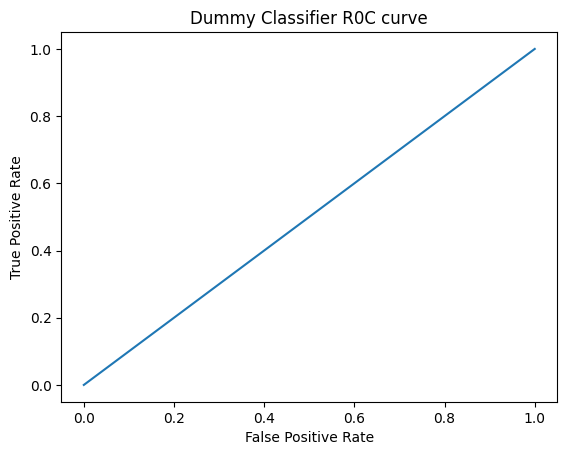

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


Model run : 18d8b18999db43589bac62779eff2950


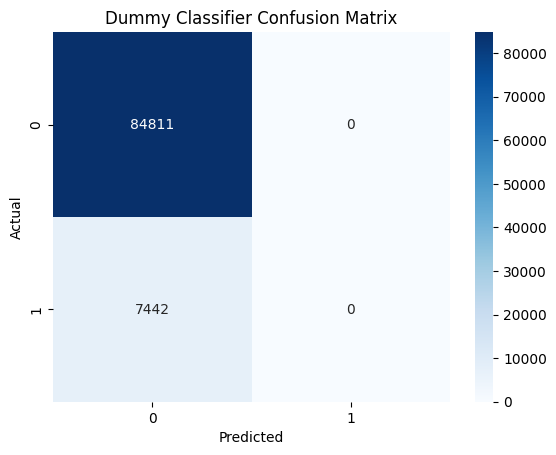

In [99]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Dummy Classifier'):
    train(pipe_dummy, X_train, y_train)
    evaluate(pipe_dummy, X_test, y_test, "Dummy Classifier")
    predictions = pipe_dummy.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(pipe_dummy, "dummy_classifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

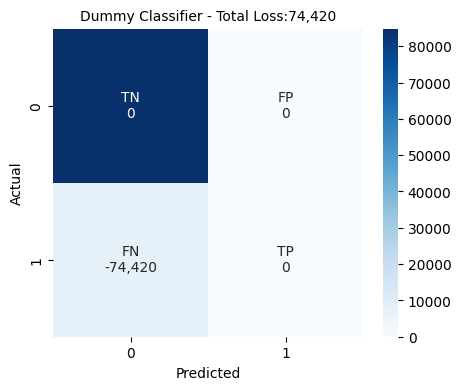

In [100]:
fig, ax = plt.subplots(figsize=(5, 4))
fig, cost = cost_matrix_heatmap(y_test, dummy_clf.predict(X_test), ax)
ax.set_title(f"Dummy Classifier - Total Loss:{cost:,}", fontsize=10);

## Logistic Regression

Nous utilisons RandomizedSearchCV pour optimiser les hyperparamètres des modèles testés. GridsearchCV nécessitait trop de temps de traitement et BayesSearchCV ne permettait pas de prendre en compte plusieurs scores. 
- RandomizedSearchCV est plus efficace dans le cas de large dataset car il n'entraine pas un modèle distinct pour chaque combinaison d'hyeprparamètres (mais un nombre spécifié de modèles utilisant des échantillons aléatoires des distributions d'hyperparamètres)
- RandomizedSearchCV peut etre plus robuste à l'overfitting dans la mesure où il ne recherche pas de manière exhaustive l'espace de recherche

In randomizedsearchcv, instead of providing a discrete set of values to explore on each hyperparameter, a statistical distribution or list of hyper parameters is provided. Values for the different hyper parameters are picked up at random from this distribution.

In [32]:
def pileline_randomsearch(model, params):
    """definition de la pipeline pour entrainer le modèle"""
    
    pipe = imbpipeline(steps=[('scaler', MinMaxScaler()),
                              ('smote', SMOTE(random_state=42)),
                              ('classifier', model)])
    
    str_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = {"accuracy":"accuracy",
              "auc":"roc_auc",
              "recall":"recall",
              "error_cost":error_cost_score,
              "error_score":error_cost_std_score}
    
    clf = RandomizedSearchCV(estimator=pipe,
                           param_distributions=params,
                           scoring=scores,
                           refit="error_score",
                           cv=str_kfold,
                           n_jobs=2)
    
    return clf

In [36]:
mlflow.sklearn.autolog(log_models=True)

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Logistic Regression') as run:

    param_logistic_regression = {'classifier__penalty': ['l1','l2',None],
                                 'classifier__C': [1, 10, 100],
                                 'classifier__solver': ['lbfgs', 'saga', 'sag']
                                 }

    clf_logistic = pileline_randomsearch(model=LogisticRegression(class_weight='balanced',
                                                                    random_state=42,
                                                                    max_iter=1000), # on limite le nb d'itération pour limiter le temps de recherche (à optimiser par la suite si besoin)
                              params=param_logistic_regression)

    clf_logistic.fit(X_train, y_train)

#117m

2023/10/03 18:12:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/10/03 18:12:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing value

## Light GBM

In [33]:
# changement du nom des colonnes car '[LightGBM] Do not support special JSON characters in feature name'
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_train_lgbm = X_train.rename(columns=new_names)

In [34]:
mlflow.sklearn.autolog(log_models=True)

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='LightGBM') as run:

    param_lgbm = {'classifier__max_depth': [10,30,60], # max depth of tree (lower to prevent overfitting) ; default: -1
                  'classifier__num_leaves': [20,50,70], # max tree leaves for base learners ; default: 31
                  'classifier__learning_rate': [0.001, 0.01, 0.1] # boosting learning rate ; default: 0.1
                  }

    clf_lgbm = pileline_randomsearch(model=LGBMClassifier(objective='binary', class_weight='balanced', random_state=42),
                              params=param_lgbm)

    clf_lgbm.fit(X_train_lgbm, y_train)

#7min

2023/10/03 17:46:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/10/03 17:46:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing value

[LightGBM] [Info] Number of positive: 158297, number of negative: 158297
[LightGBM] [Info] Number of positive: 158296, number of negative: 158296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.227231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46922
[LightGBM] [Info] Number of data points in the train set: 316594, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46566
[LightGBM] [Info] Number of data points in the train set: 316592, number of used features: 223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> ini

/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 158297, number of negative: 158297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46689
[LightGBM] [Info] Number of data points in the train set: 316594, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 158297, number of negative: 158297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46863
[LightGBM] [Info] Number of data points in the train set: 316594, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> ini

2023/10/03 17:53:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/10/03 17:53:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encounte

## XGBoost

In [35]:
mlflow.sklearn.autolog(log_models=True)

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='XGBoost') as run:

    param_xgb = {'classifier__max_depth': [10 ,30, 60],
                  'classifier__min_child_weight': [10, 20, 50], # If there are fewer than min_child_weight samples at that node, the node becomes a leaf and is no longer split
                  'classifier__subsample' : [0.5, 0.7, 1],
                  'classifier__eta': [0.001, 0.01, 0.1],
                  }

    clf_xgb = pileline_randomsearch(model=XGBClassifier(class_weight='balanced', objective='binary:logistic', random_state=42),
                              params=param_xgb)

    clf_xgb.fit(X_train, y_train)

    # 18min

2023/10/03 17:54:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/10/03 17:54:07 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight='balanced', colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
     ...`
2023/10/03 17:54:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/estellecampos/Documents/Reconversion/Formation

In [37]:
mlflow.autolog(disable=True)

## Comparaison

In [15]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [17]:
dummy_clf = mlflow.sklearn.load_model("runs:/18d8b18999db43589bac62779eff2950/dummy_classifier")
clf_logistic = mlflow.sklearn.load_model("runs:/3fc3febff05442c5bc3a80ba525f0f87/model")
clf_lgbm = mlflow.sklearn.load_model('runs:/84cca818fe16421cb21a6cfc6d48e174/model')
clf_xgb = mlflow.sklearn.load_model("runs:/258eb19c4ecb4c3ba4fbd081d32e8aab/model")

In [18]:
model_dict = {
    'Logistic Regression': clf_logistic,
    'LightGBM': clf_lgbm,
    'XGBoost': clf_xgb
}

result = {'Model': [],
          'Error_cost_score': [],
          'Error_cost': [],
          'AUC': [],
          'Recall':[],
          'Accuracy':[],
          'Mean_fit_time': [],
          'Best_params': []}

for model_name, model in model_dict.items():
    result['Model'].append(model_name)
    result['Error_cost_score'].append(round(model.best_score_, 4))
    result['Error_cost'].append(-round(np.nanmin(model.cv_results_['mean_test_error_cost']), 0))
    result['AUC'].append(round(np.nanmax(model.cv_results_['mean_test_auc']), 4))
    result['Recall'].append(round(np.nanmax(model.cv_results_['mean_test_recall']), 4))
    result['Accuracy'].append(round(np.nanmax(model.cv_results_['mean_test_accuracy']), 4))
    result['Mean_fit_time'].append(np.around(np.average(model.cv_results_['mean_fit_time']), 2))
    result['Best_params'].append(model.best_params_)

predictions = dummy_clf.predict(X_test)
result['Model'].append("Dummy Classifier")
result['Error_cost_score'].append(round(error_cost_std(y_test, predictions), 4))
result['Error_cost'].append(round(error_cost(y_test, predictions), 0))
result['AUC'].append(round(roc_auc_score(y_test, predictions), 4))
result['Recall'].append(round(recall_score(y_test, predictions), 4))
result['Accuracy'].append(round(accuracy_score(y_test, predictions), 4))
result['Mean_fit_time'].append(32)
result['Best_params'].append("most_frequent")

result_table = pd.DataFrame(result).sort_values(by='Error_cost_score', ascending=False)
result_table

,Model,Error_cost_score,Error_cost,AUC,Recall,Accuracy,Mean_fit_time,Best_params
0,Logistic Regression,0.9247,23186.0,0.7515,0.6621,0.7080,201.95,"{'classifier__solver': 'lbfgs', 'classifier__p..."
2,XGBoost,0.9223,34219.0,0.7638,0.1761,0.9190,40.00,"{'classifier__subsample': 0.7, 'classifier__mi..."
1,LightGBM,0.9210,34565.0,0.7673,0.3773,0.9192,14.07,"{'classifier__num_leaves': 70, 'classifier__ma..."
3,Dummy Classifier,0.9193,74420.0,0.5000,0.0000,0.9193,32.00,most_frequent


In [20]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test_lgbm = X_test.rename(columns=new_names)

In [21]:
y_preds = []
predict_times = []

model_dict["Dummy Classifier"] = dummy_clf

for model in list(model_dict.values()):
    if model == clf_lgbm:
        start_time = time.time()
        preds = model.predict(X_test_lgbm)
        end_time = time.time()
    else:
        start_time = time.time()
        preds = model.predict(X_test)
        end_time = time.time()
    y_preds.append(preds)
    predict_times.append(round(end_time - start_time,2))

print(predict_times)

[0.11, 1.37, 0.26, 0.07]


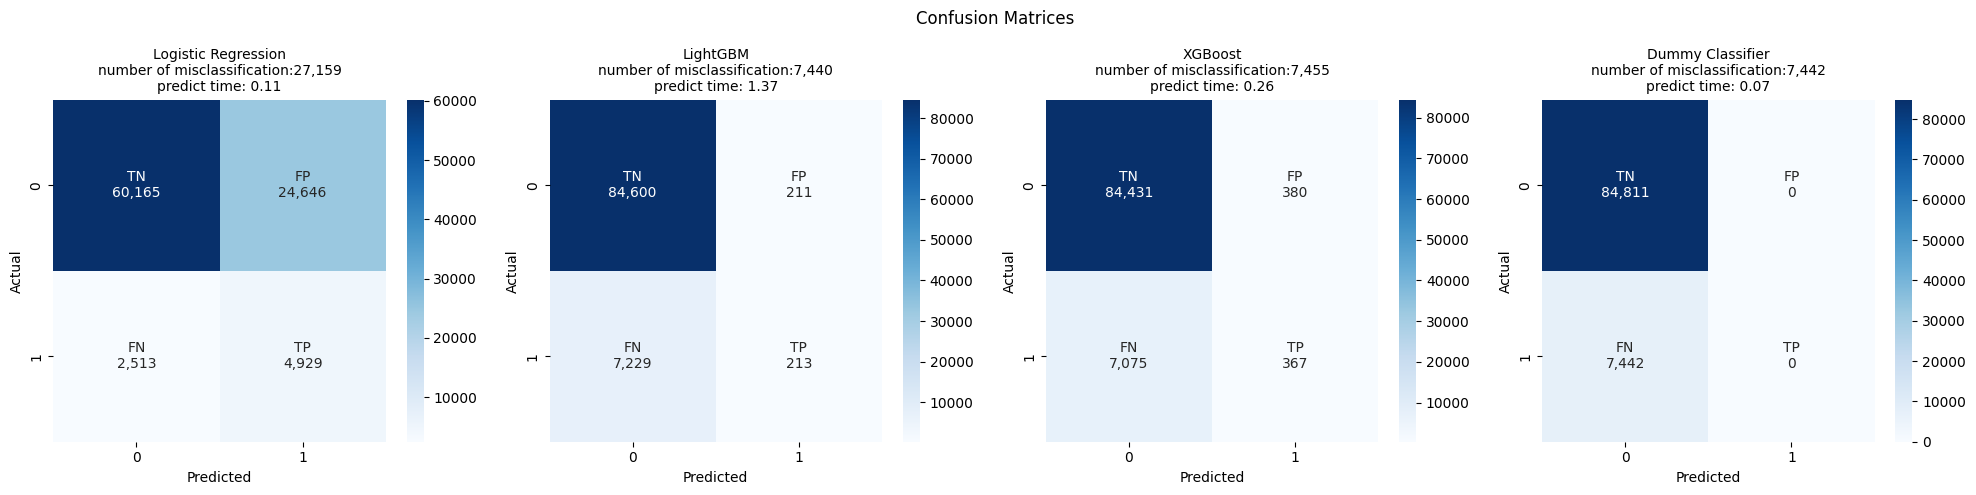

Le modèle qui génère le plus d'erreur de classification est Logistic Regression


In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

error = []
for i, ax in enumerate(axs.flatten()):
    confusion_matrix_heatmap(y_test, y_preds[i], ax)
    nb_error = error_count(y_test, y_preds[i])
    error.append(nb_error)
    ax.set_title(f"{list(model_dict.keys())[i]}\nnumber of misclassification:{nb_error:,.0f}\npredict time: {predict_times[i]}", fontsize=10)

plt.suptitle('Confusion Matrices', fontsize=12)
plt.tight_layout()
plt.show()

id = error.index(max(error))
print(f"Le modèle qui génère le plus d'erreur de classification est {list(model_dict.keys())[id]}")

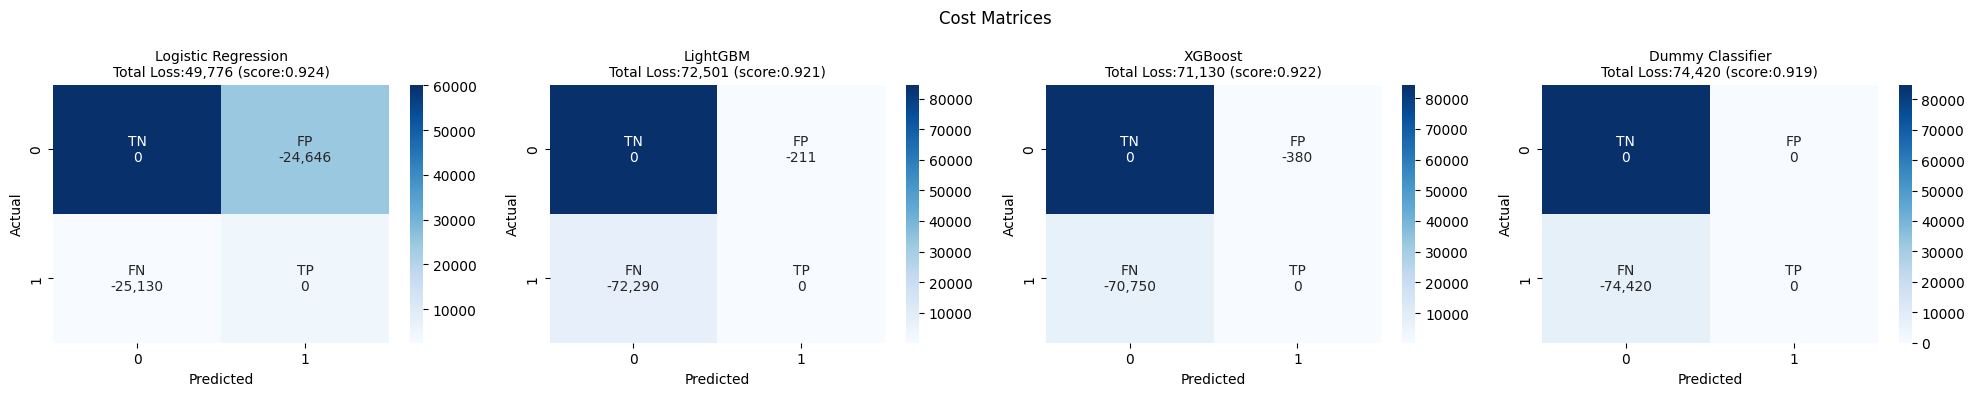

Le modèle qui génère le plus de cout est Dummy Classifier


In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

costs = []
for i, ax in enumerate(axs.flatten()):
    fig, cost = cost_matrix_heatmap(y_test, y_preds[i], ax)
    cost_score = error_cost_std(y_test, y_preds[i])
    ax.set_title(f"{list(model_dict.keys())[i]}\nTotal Loss:{cost:,} (score:{cost_score:.3f})", fontsize=10)
    costs.append(cost)

plt.suptitle('Cost Matrices', fontsize=12)
plt.tight_layout()
plt.show()

id = costs.index(max(costs))
print(f"Le modèle qui génère le plus de cout est {list(model_dict.keys())[id]}")

Le modèle Logistic Regression commet le plus d'erreur au total, mais ses erreurs sont les moins couteuses

In [24]:
def get_total_revenue(model):
    """definition d'une fonction de revenue en fonction du type et du nombre d'erreurs de classification"""

    if model == clf_lgbm:
        y_pred = model.predict(X_test_lgbm)
    else:
        y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.flatten()

    total_revenue = 50*TN - 0*FP - 140*FN + 0*TP
    # chaque client correctement identifié comme solvable et à qui je prete de l'argent (TN) me rapporte 50
    # les clients à qui je ne ne prete pas car je les ai identifié comme non solvable à tort ou a raison (FP ou TP) me rapporte 0
    # les clients à qui je prête alors qu'ils sont insolvables (FN) me coute 140
    
    return total_revenue

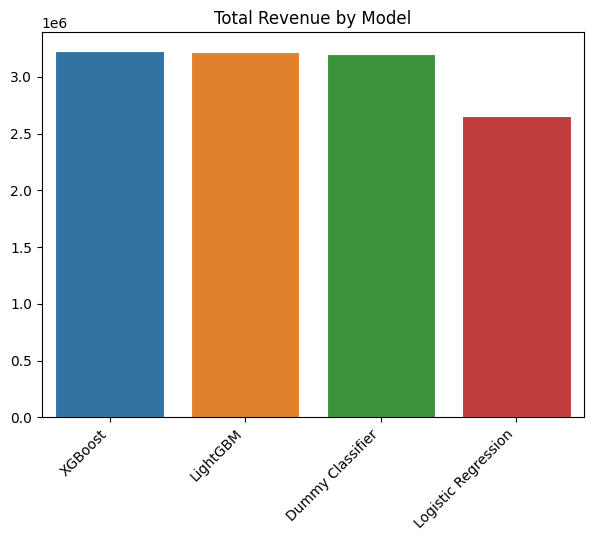

In [25]:
revenues = [get_total_revenue(model) for model in model_dict.values()]
sorted_models = [model for _, model in sorted(zip(revenues, model_dict.values()), reverse=True)]

plt.figure(figsize=(7,5))
sns.barplot(x=list(model_dict.keys()), 
            y=revenues, 
            edgecolor='white',
            linewidth=0.8,
            order=[list(model_dict.keys())[list(model_dict.values()).index(model)] for model in sorted_models])
plt.xticks(rotation=45, ha='right')
plt.title('Total Revenue by Model',fontsize=12)
plt.show()

In [46]:
get_total_revenue(clf_logistic)

2656430

Le modèle XGBoost génère le plus de revenue au total car c'est le modèle qui a le plus de "True Negative", donc qui détecte le mieux les clients qui ne feront pas default. Cette otpimisation du revenue se fait au détriment du cout, car le modèle XGBoost commet beaucoup d'erreur "False Negative" (classification d'un client qui va faire défault en bon client).

## Optimisation du modèle choisi

Nous avons mis en place une validation croisée (via RandomizedSearchCV) afin d’optimiser les hyperparamètres et comparer les modèles. 
Nous allons à présent affiner les valeurs d’hyperparamètres pour l’algorithme final choisi.

L'activité d'une banque est par nature averse au risque, nous allons donc sélectionner le modèle qui fait le moins d'erreur couteuse (au détriment d'un meilleur résultat) : **logistic regression**

In [26]:
clf_logistic_best = mlflow.sklearn.load_model("runs:/3fc3febff05442c5bc3a80ba525f0f87/best_estimator")

In [37]:
result_logreg = pd.DataFrame(clf_logistic.cv_results_)
result_logreg.sort_values("rank_test_error_score", ascending=True)[["param_classifier__solver","param_classifier__penalty","param_classifier__C"]].iloc[0]

param_classifier__solver     lbfgs
param_classifier__penalty       l2
param_classifier__C            100
Name: 5, dtype: object

In [39]:
clf_logistic_best.fit(X_train, y_train)
#1m50

/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

In [40]:
# necessary or not ? on refait tourner une pipeline avec un nombre d'iteration plus importante pour que ca converge (ne converge pas avec 1000 itération)

model = LogisticRegression(solver='lbfgs', penalty='l2', C=100, class_weight='balanced', random_state=42, max_iter=5000)

pipe_logreg = imbpipeline(steps=[('scaler', MinMaxScaler()),
                              ('smote', SMOTE(random_state=42)),
                              ('classifier', model)])

pipe_logreg.fit(X_train, y_train)
#3m20

Pipeline(steps=[('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=5000, random_state=42))])

Train accuracy: 0.707
Train AUC: 0.689
Train recall: 0.667
Train error cost: 115,134
Train error score: 0.925

Eval accuracy: 0.705
Eval AUC: 0.685
Eval recall: 0.662
Eval error cost: 49,858
Eval error score: 0.924


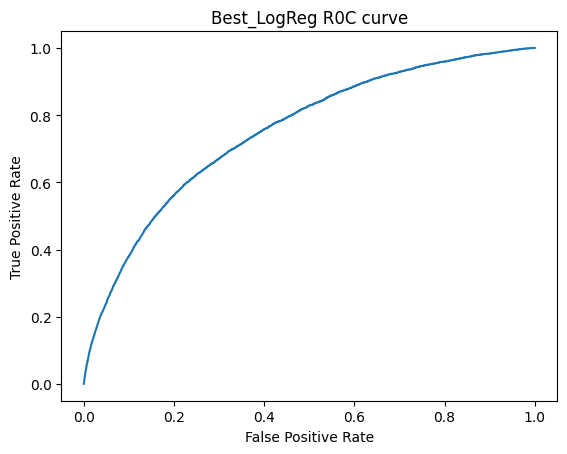

/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Model run : f19aa71fe57f438ab3a6d3228ba735db


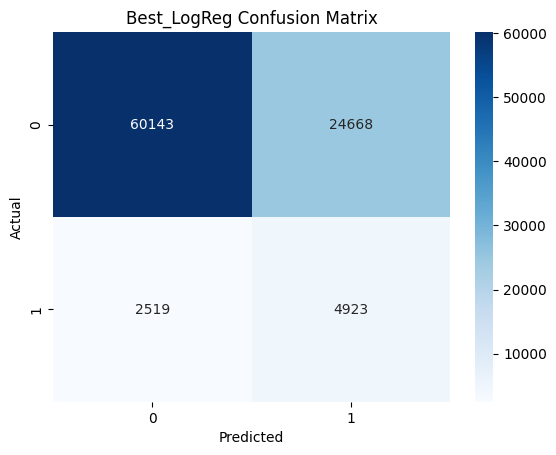

In [48]:
experiment = mlflow.get_experiment(772359175680480228) #ID for "credit_scoring" experiment
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Best_LogReg'):
    train(pipe_logreg, X_train, y_train)
    evaluate(pipe_logreg, X_test, y_test, "Best_LogReg")
    predictions = pipe_logreg.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(pipe_logreg, "Best_LogReg", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

#3m15

In [57]:
print(classification_report(y_test, pipe_logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     84811
           1       0.17      0.66      0.27      7442

    accuracy                           0.71     92253
   macro avg       0.56      0.69      0.54     92253
weighted avg       0.90      0.71      0.77     92253



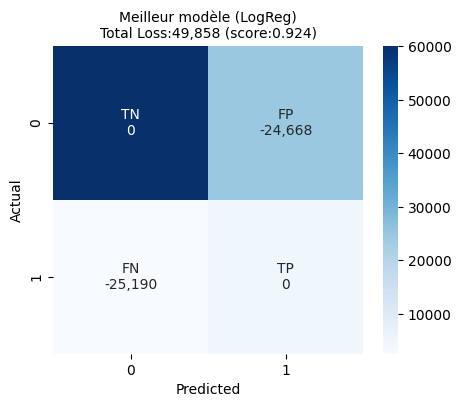

In [44]:
fig, ax = plt.subplots(figsize=(5, 4))
fig, cost = cost_matrix_heatmap(y_test, pipe_logreg.predict(X_test), ax)
cost_score = error_cost_std(y_test, pipe_logreg.predict(X_test))
ax.set_title(f"Meilleur modèle (LogReg)\nTotal Loss:{cost:,} (score:{cost_score:.3f})", fontsize=10);

In [45]:
get_total_revenue(pipe_logreg)

2654490

In [49]:
# save the model with joblib
import joblib
joblib.dump(pipe_logreg, 'best_logreg.joblib')

['best_logreg.joblib']

In [50]:
# save the model with mlflow
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipe_logreg, 'mlflow_logreg_best', signature=signature)

/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/env/lib/python3.9/site-packages/mlflow/models/signature.py:213: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  outputs = _infer_schema(model_output) if model_output is not None else None


In [51]:
# model registry for version control
logreg_best = mlflow.register_model("runs:/f19aa71fe57f438ab3a6d3228ba735db/Best_LogReg", "logreg_best")

# change model stage (Staging / Archived / Production / None)
#client = MlflowClient()
#client.transition_model_version_stage(name="logreg_best", version=1, stage="Production")

Successfully registered model 'logreg_best'.
2023/10/04 10:00:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: logreg_best, version 1
Created version '1' of model 'logreg_best'.


## Feature importance

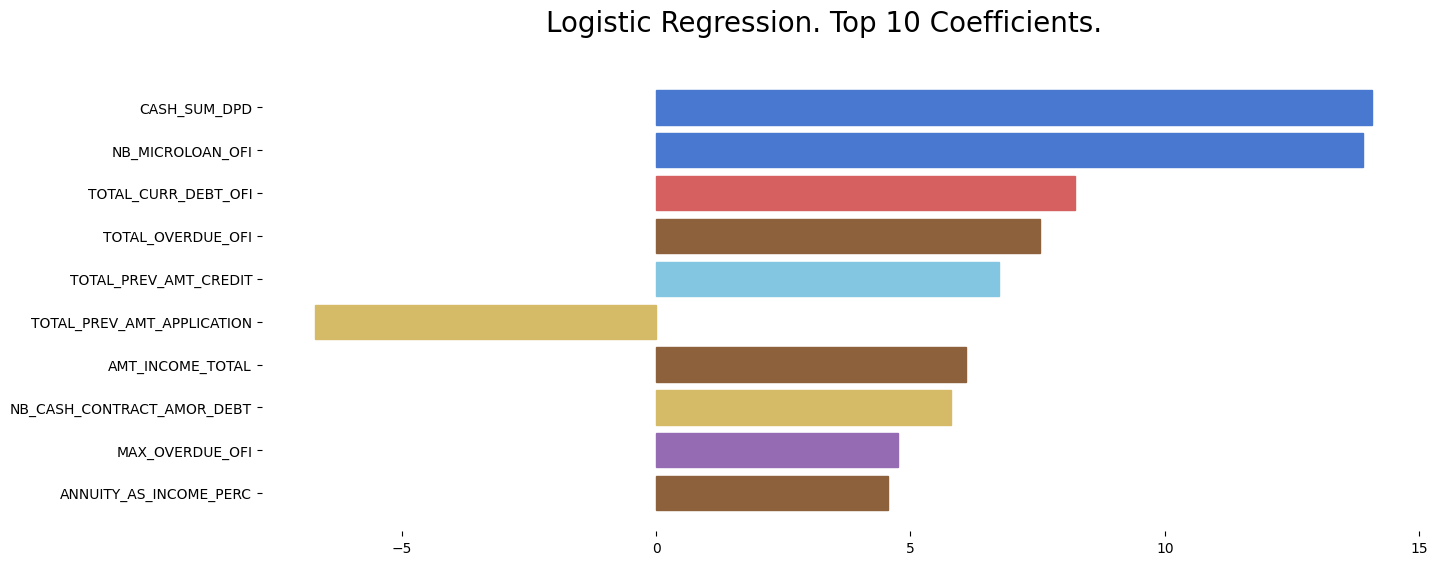

In [68]:
plt.figure(figsize=(15,6))
logistic_reg_coeff = pipe_logreg["classifier"].coef_
color_list = sns.color_palette("muted", len(X_train.columns)) 
top_x = 10
logistic_reg_coeff = pipe_logreg["classifier"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(X_train.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

In [52]:
import shap
shap.initjs()

### Global interpretation

Analyse des features qui contribuent le plus au modèle en général : quels sont les features qui influencent le plus la décision de prêter ou de rejetter une demande de prêt

In [77]:
clf = pipe_logreg["classifier"]
scaler = pipe_logreg["scaler"]

scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 100, random_state=0) # only 100 samples of train data, otherwise takes too long
scaled_test_data = scaler.transform(X_test)

In [78]:
# creation of LinearExplainer by giving model and train data as input
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)

In [ ]:
#shap_values_g = explainer.shap_values(scaled_test_data) -> takes 4 hours for only 7% (57h for 100%)

In [ ]:
df_shapvalues = pd.DataFrame(shap_values_g, columns=X_train.columns.tolist())
# export des shap values dans un csv pour pouvoir accéder aux valeurs rapidement (le calcul des shap values ets très long)
df_shapvalues.to_csv("/Users/estellecampos/Documents/Reconversion/Formation OpenClassroom/Projet_7/data/clean/shape_values_logreg.csv")

In [ ]:
# récupération des shap values
#df_shapvalues = pd.read_csv("./data/clean/shape_values_logreg.csv")
#df_shapvalues = df_shapvalues.drop(['Unnamed: 0'], axis=1)
df_shapvalues.head()

In [ ]:
# feature importance of each feature in the model
shap.summary_plot(shap_values_g, scaled_test_data)

In [ ]:
shap.plots.waterfall(shap_values_g[0])

In [ ]:
# feature importance for label 1
shap.summary_plot(shap_values_g[1], scaled_test_data)

In [ ]:
# look at customer samples with label 1
shap.plots.force(explainer.expected_value[1], shap_values_g[1][6,:], scaled_test_data.iloc[6,:], matplotlib=True)

In [ ]:
# each plotted line show how strongly the individual features contributed to a single model prediction (tilted toward 1)
shap.decision_plot(explainer.expected_value[1], shap_values_g[1], X_test.columns)

In [ ]:
# each plotted line show how strongly the individual features contributed to a single model prediction (tilted toward 0)
shap.decision_plot(explainer.expected_value[0], shap_values_g[0], X_test.columns)

### Local interpretation

In [82]:
test_data_idx = 10 #np.random.randint(len(X_test))
subsampled_test_data = scaled_test_data[test_data_idx].reshape(1,-1)
shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")

100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


In [96]:
print("SHAP expected value", explainer.expected_value)
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
print("Shap values to add to base value", shap_values[0].sum())

SHAP expected value [0.60639945 0.39360055]
Model prediction for test data [[0.31788429 0.68211571]]
Shap values to add to base value -0.28851515690597884


In [84]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)

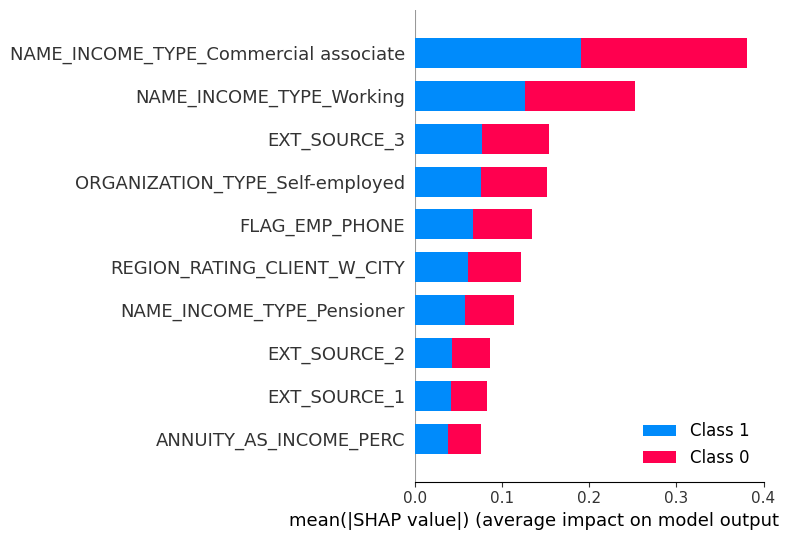

In [85]:
shap.summary_plot(shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10)